# This notebook calculates MOD for a specified area and all complete years for a given sensor.

## Spatial data from rSIR and GRD are displayed using cartopy, with elevation data.


## Load in all the modules needed

In [1]:
%pylab notebook
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np
import pandas as pd
import rasterio
from cetbtools.ease2conv import Ease2Transform
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
# navigate to where scripts are saved
%cd /projects/brodzik/ipynb_melt_onset/scripts/
%ls

/projects/brodzik/ipynb_melt_onset/scripts
CETB_algorithms.py  CETB_analysis.py~       __pycache__/
CETB_analysis.py    CETB_read_functions.py


In [3]:
# load the custom functions
from CETB_read_functions import read_Tb
from CETB_read_functions import coords
from CETB_read_functions import calc_DAV
from CETB_read_functions import find_UIB_cube_offset
from CETB_read_functions import grid_locations_of_UIB
from CETB_algorithms import DAV_MOD
from CETB_analysis import MOD_array
from CETB_analysis import MOD_array_year

## Specify inputs

In [4]:
#Specify region, satellite, sensor, channel, and image reconstruction algorithm of interest in file name
# this notebook will read in 2 CETB datasets so that channels/algorithms/sensors can be compared
region='UIB'  #make this the same syntax as cubefilenames and sub-directory
platform='AQUA'   #'AQUA' for AMSRE, 'F13','F14','F15'... for SSMI
sensor='AMSRE'  #'AMSRE', 'SSMI', etc.
channel='36V'  #'36V','36H', '18V','18H', etc. '19V','19H' and '37V','37H' for SSMI)
version='v1.3'
proj='N'

if sensor=='SSMI':
    provider='CSU' 
elif sensor=='AMSRE':
    provider='RSS'

cubeDir = '/work/PMESDR/CETB_v1.3/%s_%s/%s/cubes_%s/' % (platform, sensor, proj, region)    

# prefix filepath
prefix_GRD = 'CETB.cubefile.%s.%s_%s-%s-GRD-%s-%s' % (region, platform, sensor, channel, provider, version)
prefix_SIR = 'CETB.cubefile.%s.%s_%s-%s-SIR-%s-%s' % (region, platform, sensor, channel, provider, version)

# years for each sensor
# F13, May 95 - Nov 09
if platform=='F13':
    # F13, May 95 - Nov 09
    Years = [2002,2003,2004,2005,2006,2007,2008,2009]
elif platform=='F14':
    # F14, May 97 - Aug 08
    Years=[2002,2003,2004,2005,2006,2007,2008]
elif platform=='F15':
    # F15, Feb 00 - Jun 17
    Years=[2002,2003,2004,2005,2006,2007,2008,2009,2010,2011]
elif platform=='AQUA':
    # AQUA AMSR-E: Jun 02 - Oct 11
    Years=[2003,2004,2005,2006,2007,2008,2009,2010,2011]


In [5]:
# Set up cartopy CRSs for E2N and 
# for UIB cubes, I want to rotate 90 degrees clockwise
geod = ccrs.Geodetic()
e2n = ccrs.LambertAzimuthalEqualArea(central_latitude=90.0)
e2nRotate = ccrs.LambertAzimuthalEqualArea(central_latitude=90.0, central_longitude=90.0)

# Sanity check
lon, lat = geod.transform_point(
    x = -9000000.,
    y = 9000000.,
    src_crs=e2n)
print("E2N UL corner lon=%.4f, lat=%.4f" % (lon, lat))

E2N UL corner lon=-135.0000, lat=-84.6340


# Read the UIB shapefile to get the bounds of the cube area

Read the basin outline shapefiles
Use shapely to read the .shp files. This works for lonlat shapefiles, it doesn't seem to work for projected ones, there must be an option that I'm just missing.

Use the cartopy CRS to project the shapefile to E2N

In [6]:
UIBBasinfile = '/work/charis/ti_model/basins/basin_outlines/UIB_Khan/UIB_shape_file/Upstream_Tarbela_lonlat.shp'
UIBReader = shpreader.Reader(UIBBasinfile)
UIBRecord = next(UIBReader.records())
UIBRecord, UIBRecord.attributes, UIBRecord.bounds, UIBRecord.geometry

(<Record: <shapely.geometry.multipolygon.MultiPolygon object at 0x2acb355f6dd8>, {'OBJECTID': 0, 'Shape_Leng': 0.0, 'Shape_Area': 172173.496284, 'HydroID': -281, 'Name': 'Tarbela Dam*'}, <fields>>,
 {'OBJECTID': 0,
  'Shape_Leng': 0.0,
  'Shape_Area': 172173.496284,
  'HydroID': -281,
  'Name': 'Tarbela Dam*'},
 (72.20510869192658,
  31.101009176780153,
  81.82542454706251,
  37.089310863423584),
 <shapely.geometry.multipolygon.MultiPolygon at 0x2acb355f6dd8>)

In [7]:
hunzaBasinfile = '/work/charis/ti_model/basins/basin_outlines/IN_Hunza_at_DainyorBridge.shp'
hunzaReader = shpreader.Reader(hunzaBasinfile)
hunzaRecord = next(hunzaReader.records())
hunzaRecord, hunzaRecord.attributes, hunzaRecord.bounds, hunzaRecord.geometry

(<Record: <shapely.geometry.multipolygon.MultiPolygon object at 0x2acb3ba8c208>, {'GRDC_NO': 2335100, 'WMO_REG': 2, 'SUB_REG': 35, 'MIX_REG': 235, 'NAT_ID': '1001', 'RIVER': 'HUNZA RIVER', 'STATION': 'DANYOUR BRIDGE', 'COUNTRY_CO': 'PK', 'LAT_ORG': 35.92, 'LONG_ORG': 74.38, 'LAT_NEW': 35.9271, 'LONG_NEW': 74.3729, 'DIST_KM': 1.0, 'AREA': 12950.0, 'AREA_HYS': 13746.4, 'AREA_DIFF': 6.1, 'ALTITUDE': -999.0, 'ELEV_HYS': 1446, 'DS_STAT_NO': 2335200, 'W_LEVEL': 0, 'D_START': 1978, 'D_END': 1982, 'D_YRS': 5, 'D_MISS': 20, 'M_START': 1978, 'M_END': 1982, 'M_YRS': 5, 'M_MISS': 20, 'T_START': 1978, 'T_END': 1982, 'T_YRS': 5, 'LTA_DISCHA': 381.128, 'DISC_HYS': 55.74, 'DISC_DIFF': -85.4, 'R_VOLUME_Y': 12, 'R_HEIGHT_Y': 928, 'PROC_TYRS': 80, 'PROC_TMON': 100, 'F_IMPORT': '16.1.1992', 'F_IM_YR': 1992, 'L_IMPORT': '10.5.1996', 'L_IM_YR': 1996, 'PROVIDER_I': -999, 'ACSYS': 0, 'FLUX2OCEAN': 0, 'GEMS': 0, 'GCOS_GTN_H': 0, 'STATISTICS': 0, 'CODE': 2, 'QUALITY': 'Medium', 'TYPE': 'Automatic', 'COMMENT': '

## Rotate/project the basin outline shapefiles

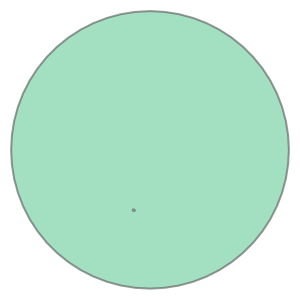

In [8]:
e2nRotateHunzaBasin = e2nRotate.project_geometry(hunzaRecord.geometry)
e2nRotateHunzaBasin

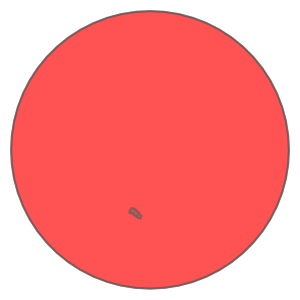

In [9]:
e2nRotateUIBBasin = e2nRotate.project_geometry(UIBRecord.geometry)
e2nRotateUIBBasin

In [10]:
UIBRecord.bounds, hunzaRecord.bounds

((72.20510869192658,
  31.101009176780153,
  81.82542454706251,
  37.089310863423584),
 (74.02507731119763, 35.92307128906174, 75.77779744466116, 37.09783732096277))

In [11]:
bounds = hunzaRecord.bounds
Site = "Hunza"
#bounds = UIBRecord.bounds
#Site = "UIB"
bounds

(74.02507731119763, 35.92307128906174, 75.77779744466116, 37.09783732096277)

In [12]:
# SPECIFY latitude and longitude in decimal degrees, need to choose lat/lon corners so that we will load
# in a rectangle of pixels that enclose these coordinates
lat_start = bounds[1]
lat_end = bounds[3]
lon_start = bounds[0]
lon_end = bounds[2]

In [13]:
# get the GRD pixel IDs for the lat/lon rectangle chosen
rows_cols_GRD=coords(cubeDir, prefix_GRD, lat_start, lat_end, lon_start, lon_end)
rows_cols_GRD

(26, 34, 3, 9)

In [14]:
# row and col numbers of all the SIR pixels contained by the GRD pixels
# FIXME: this assumes SIR is 3.125 km data
rows_cols_env=[rows_cols_GRD[0]*8,rows_cols_GRD[1]*8, rows_cols_GRD[2]*8, rows_cols_GRD[3]*8]
rows_cols_env

[208, 272, 24, 72]

In [15]:
# load in SIR TB data
data_SIR=read_Tb(cubeDir, prefix_SIR, Years,rows_cols_env[0],rows_cols_env[1],rows_cols_env[2],rows_cols_env[3])
CETB_SIR=data_SIR['TB']   # 3-D Tb time-series array of TB
cal_date=data_SIR['cal_date']    # 1-D array of dates, these will get passed to later functions
cal_year=data_SIR['cal_year']    # 1-D array of years
cal_month=data_SIR['cal_month']   # 1-D array of months

# load GRD Tb data
data_GRD=read_Tb(cubeDir, prefix_GRD, Years,rows_cols_GRD[0],rows_cols_GRD[1],rows_cols_GRD[2],rows_cols_GRD[3])
CETB_GRD=data_GRD['TB']

Next filename=/work/PMESDR/CETB_v1.3/AQUA_AMSRE/N/cubes_UIB/CETB.cubefile.UIB.AQUA_AMSRE-36V-SIR-RSS-v1.3.2003.TB.nc...
Next filename=/work/PMESDR/CETB_v1.3/AQUA_AMSRE/N/cubes_UIB/CETB.cubefile.UIB.AQUA_AMSRE-36V-SIR-RSS-v1.3.2004.TB.nc...
Next filename=/work/PMESDR/CETB_v1.3/AQUA_AMSRE/N/cubes_UIB/CETB.cubefile.UIB.AQUA_AMSRE-36V-SIR-RSS-v1.3.2005.TB.nc...
Next filename=/work/PMESDR/CETB_v1.3/AQUA_AMSRE/N/cubes_UIB/CETB.cubefile.UIB.AQUA_AMSRE-36V-SIR-RSS-v1.3.2006.TB.nc...
Next filename=/work/PMESDR/CETB_v1.3/AQUA_AMSRE/N/cubes_UIB/CETB.cubefile.UIB.AQUA_AMSRE-36V-SIR-RSS-v1.3.2007.TB.nc...
Next filename=/work/PMESDR/CETB_v1.3/AQUA_AMSRE/N/cubes_UIB/CETB.cubefile.UIB.AQUA_AMSRE-36V-SIR-RSS-v1.3.2008.TB.nc...
Next filename=/work/PMESDR/CETB_v1.3/AQUA_AMSRE/N/cubes_UIB/CETB.cubefile.UIB.AQUA_AMSRE-36V-SIR-RSS-v1.3.2009.TB.nc...
Next filename=/work/PMESDR/CETB_v1.3/AQUA_AMSRE/N/cubes_UIB/CETB.cubefile.UIB.AQUA_AMSRE-36V-SIR-RSS-v1.3.2010.TB.nc...
Next filename=/work/PMESDR/CETB_v1.3/AQU

In [16]:
# calculate DAV for the Tb data that was imported
DAV_SIR=calc_DAV(CETB_SIR)
DAV_GRD=calc_DAV(CETB_GRD)

In [17]:
# Given a cube's (or subset's) x, y values
# calculate the extent of the edges 
# as 1/2 pixel larger than centers of corner pixels
def get_extent_xy(x, y):
    # Assumes pixels with regular spacing
    scale_x = x[1] - x[0]
    scale_y = y[1] - y[0]
    print("scales: ", scale_x, scale_y)
    
    extent = [x[0] - (scale_x/2.),
              x[-1] + (scale_x/2.),
              y[-1] + (scale_y/2.),
              y[0] - (scale_y/2.)]
              
    return extent

## Check extents of full cube

In [18]:
data_GRD['x'].shape, data_GRD['y'].shape

((35,), (45,))

In [19]:
get_extent_xy(data_SIR['x'], data_SIR['y'])

scales:  3125.0 -3125.0


[5400000.0, 6275000.0, -1875000.0, -750000.0]

In [20]:
get_extent_xy(data_GRD['x'], data_GRD['y'])

scales:  25000.0 -25000.0


[5400000.0, 6275000.0, -1875000.0, -750000.0]

## Check extents of requested subsets

In [21]:
get_extent_xy(data_SIR['x'][rows_cols_env[2]:rows_cols_env[3]],
              data_SIR['y'][rows_cols_env[0]:rows_cols_env[1]])

scales:  3125.0 -3125.0


[5475000.0, 5625000.0, -1600000.0, -1400000.0]

In [22]:
get_extent_xy(data_GRD['x'][rows_cols_GRD[2]:rows_cols_GRD[3]],
              data_GRD['y'][rows_cols_GRD[0]:rows_cols_GRD[1]])

scales:  25000.0 -25000.0


[5475000.0, 5625000.0, -1600000.0, -1400000.0]

## Read DEMs at 3.125 and 25 km for displays

In [23]:
DEM25kmFile = '/work/charis/ti_model/SRTMGL3_version2_EASE2/EASE2_N25km.CHARIS_DEM_v2_IN.UIB_Khan_clip.mode.tif'
with rasterio.open(DEM25kmFile) as src:
    dem25km = np.squeeze(src.read())
DEM3kmFile = '/work/charis/ti_model/SRTMGL3_version2_EASE2/EASE2_N3.125km.CHARIS_DEM_v2_IN.UIB_Khan_clip.mode.tif'
with rasterio.open(DEM3kmFile) as src:
    dem3km = np.squeeze(src.read())

## create arrays of MOD to be used for plotting

In [24]:
# get array of average MODs for SIR pixels for all the years loaded
window=10   # window for MOD algorithm, '10' would be 5 days (2 measurements per day)
count=3    # number of Tb/DAV exceedances to trigger MOD
DAV_threshold=40
Tb_threshold=252

In [25]:
Years

[2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]

In [26]:
# sir MOD array - MOD will be in day of year (DOY)
t = time.process_time()
MOD_DOY_array=MOD_array(cubeDir, prefix_SIR, CETB_SIR, DAV_SIR, 
                        rows_cols_env, cal_date, Years, window, count, DAV_threshold, Tb_threshold)
elapsed_time = time.process_time() - t
MOD_DOY_array, elapsed_time

newdata.shape (6574, 3072)
moving flag array to newdata...
number of days = 6574
Next d = 0
Next d = 100
Next d = 200
Next d = 300
Next d = 400
Next d = 500
Next d = 600
Next d = 700
Next d = 800
Next d = 900
Next d = 1000
Next d = 1100
Next d = 1200
Next d = 1300
Next d = 1400
Next d = 1500
Next d = 1600
Next d = 1700
Next d = 1800
Next d = 1900
Next d = 2000
Next d = 2100
Next d = 2200
Next d = 2300
Next d = 2400
Next d = 2500
Next d = 2600
Next d = 2700
Next d = 2800
Next d = 2900
Next d = 3000
Next d = 3100
Next d = 3200
Next d = 3300
Next d = 3400
Next d = 3500
Next d = 3600
Next d = 3700
Next d = 3800
Next d = 3900
Next d = 4000
Next d = 4100
Next d = 4200
Next d = 4300
Next d = 4400
Next d = 4500
Next d = 4600
Next d = 4700
Next d = 4800
Next d = 4900
Next d = 5000
Next d = 5100
Next d = 5200
Next d = 5300
Next d = 5400
Next d = 5500
Next d = 5600
Next d = 5700
Next d = 5800
Next d = 5900
Next d = 6000
Next d = 6100
Next d = 6200
Next d = 6300
Next d = 6400
Next d = 6500
dataFra

(masked_array(data=[63.0, 76.75, 95.0, ..., nan, nan, nan],
              mask=[False, False, False, ..., False, False, False],
        fill_value=1e+20), 13.687080942)

In [27]:
# MOD of the GRD pixel - avg all years
#window=10
#count=3
#DAV_threshold=18
#Tb_threshold=252
t = time.process_time()
MOD_DOY_array_GRD=MOD_array(cubeDir, prefix_GRD, CETB_GRD, DAV_GRD, 
                            rows_cols_GRD, cal_date, Years, window, count, DAV_threshold, Tb_threshold)
elapsed_time = time.process_time() - t
MOD_DOY_array_GRD, elapsed_time

newdata.shape (6574, 48)
moving flag array to newdata...
number of days = 6574
Next d = 0
Next d = 100
Next d = 200
Next d = 300
Next d = 400
Next d = 500
Next d = 600
Next d = 700
Next d = 800
Next d = 900
Next d = 1000
Next d = 1100
Next d = 1200
Next d = 1300
Next d = 1400
Next d = 1500
Next d = 1600
Next d = 1700
Next d = 1800
Next d = 1900
Next d = 2000
Next d = 2100
Next d = 2200
Next d = 2300
Next d = 2400
Next d = 2500
Next d = 2600
Next d = 2700
Next d = 2800
Next d = 2900
Next d = 3000
Next d = 3100
Next d = 3200
Next d = 3300
Next d = 3400
Next d = 3500
Next d = 3600
Next d = 3700
Next d = 3800
Next d = 3900
Next d = 4000
Next d = 4100
Next d = 4200
Next d = 4300
Next d = 4400
Next d = 4500
Next d = 4600
Next d = 4700
Next d = 4800
Next d = 4900
Next d = 5000
Next d = 5100
Next d = 5200
Next d = 5300
Next d = 5400
Next d = 5500
Next d = 5600
Next d = 5700
Next d = 5800
Next d = 5900
Next d = 6000
Next d = 6100
Next d = 6200
Next d = 6300
Next d = 6400
Next d = 6500
dataFrame

(masked_array(data=[108.25, 107.75, 115.0, 123.44444444444444, 140.625,
                    126.33333333333333, 114.0, 116.375, 122.22222222222223,
                    115.55555555555556, 131.75, 128.33333333333334,
                    112.77777777777777, 114.22222222222223,
                    118.88888888888889, 150.0, 196.66666666666666,
                    124.66666666666667, 113.77777777777777,
                    109.77777777777777, 126.0, nan, 147.66666666666666,
                    120.22222222222223, 120.33333333333333, 120.5, nan,
                    nan, nan, 129.14285714285714, 117.66666666666667,
                    120.66666666666667, 130.83333333333334, nan, 137.0,
                    nan, 118.44444444444444, 130.88888888888889,
                    124.88888888888889, nan, nan, nan, 114.33333333333333,
                    131.66666666666666, 119.28571428571429, 118.25, 136.0,
                    98.77777777777777],
              mask=[False, False, False, False, False, F

In [ ]:
# Save these arrays to numpy zip
outfile = '/projects/brodzik/pmesdr_melt_onset/data/%s_%s_%s_%d-%d_MOD.DAV%03d.Tb%03d.npz' % (
    Site, platform, sensor, Years[0], Years[-1], DAV_threshold, Tb_threshold)
np.savez(outfile, 
         MOD_DOY_array=MOD_DOY_array, 
         MOD_DOY_array_GRD=MOD_DOY_array_GRD)
print("Avg SIR and GRD MODs saved to %s" % outfile)

In [ ]:
# For each individual year, do SIR and GRD MOD

# get array of MOD for each pixel SIR - one year of interest
#window=10
#count=3
#DAV_threshold=18
#Tb_threshold=252

# For each individual year, do SIR MOD
for year in Years:
    print("year = %d" % year)
    t = time.process_time()
    MOD_DOY_array_year=MOD_array_year(cubeDir, prefix_SIR, CETB_SIR, DAV_SIR, 
                                      rows_cols_env, cal_date, year, 
                                      window, count, DAV_threshold, Tb_threshold)
    elapsed_time = time.process_time() - t
    print("SIR elapsed time = %f" % elapsed_time)
    
    t = time.process_time()
    MOD_DOY_array_GRD_year=MOD_array_year(cubeDir, prefix_GRD, CETB_GRD, DAV_GRD, 
                                          rows_cols_GRD, cal_date, year, 
                                          window, count, DAV_threshold, Tb_threshold)
    elapsed_time = time.process_time() - t
    print("GRD elapsed time = %f" % elapsed_time)
    
    outfile = '/projects/brodzik/pmesdr_melt_onset/data/%s_%s_%s_%d_MOD.DAV%03d.Tb%03d.npz' % (
        Site, platform, sensor, year, DAV_threshold, Tb_threshold)
    np.savez(outfile, 
             MOD_DOY_array_year=MOD_DOY_array_year,
             MOD_DOY_array_GRD_year=MOD_DOY_array_GRD_year)
    print("MOD data saved to %s" % outfile)

## Load data produced earlier

In [ ]:
# This will need to be changed to read the particular year of interest
# Load data saved on previous runs
outfile = '/projects/brodzik/pmesdr_melt_onset/data/%s_%s_%s_%d-%d_MOD.DAV%03d.Tb%03d.npz' % (
    Site, platform, sensor, Years[0], Years[-1], DAV_threshold, Tb_threshold)
npzfile = np.load(outfile)
print("Loading avg data from %s" % outfile)
#npzfile.files
# should return 2 avg MOD variable names as a dict
MOD_DOY_array = npzfile['MOD_DOY_array']
MOD_DOY_array_GRD = npzfile['MOD_DOY_array_GRD']

In [129]:
# Set the year to read
year = 2003
outfile = '/projects/brodzik/pmesdr_melt_onset/data/%s_%s_%s_%d_MOD.DAV%03d.Tb%03d.npz' % (
        Site, platform, sensor, year, DAV_threshold, Tb_threshold)
npzfile = np.load(outfile)
print("Loading year=%d data from %s" % (year, outfile))
MOD_DOY_array_year = npzfile['MOD_DOY_array_year']
MOD_DOY_array_GRD_year = npzfile['MOD_DOY_array_GRD_year']

Loading year=2003 data from /projects/brodzik/pmesdr_melt_onset/data/Hunza_AQUA_AMSRE_2003_MOD.DAV040.Tb252.npz


# Convert the MOD information back to an image for display

In [130]:
MOD_DOY = MOD_DOY_array.reshape((rows_cols_env[1] - rows_cols_env[0],
                                 rows_cols_env[3] - rows_cols_env[2]))
MOD_DOY_year = MOD_DOY_array_year.reshape((rows_cols_env[1] - rows_cols_env[0],
                                           rows_cols_env[3] - rows_cols_env[2]))
                                         
MOD_DOY_GRD = MOD_DOY_array_GRD.reshape((rows_cols_GRD[1] - rows_cols_GRD[0],
                                         rows_cols_GRD[3] - rows_cols_GRD[2]))
MOD_DOY_GRD_year = MOD_DOY_array_GRD_year.reshape((rows_cols_GRD[1] - rows_cols_GRD[0],
                                                   rows_cols_GRD[3] - rows_cols_GRD[2]))

# Just plot the SIR/GRD for one year

<IPython.core.display.Javascript object>


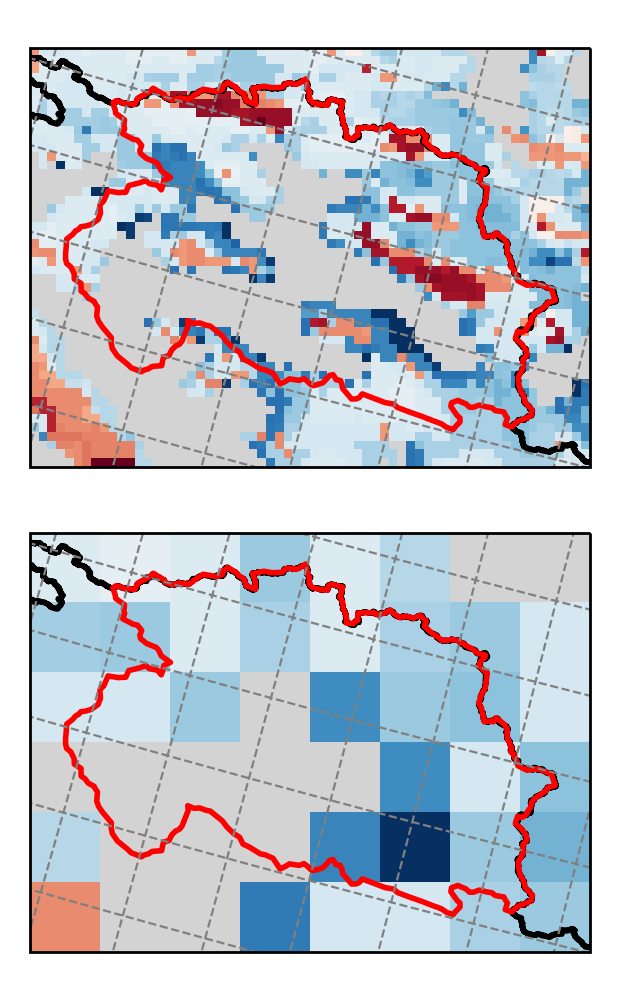

scales:  25000.0 -25000.0
Saved plot to /projects/brodzik/pmesdr_melt_onset/data/Hunza_AQUA_AMSRE_2003.MOD.DAV040.Tb252.png


In [131]:
do_colorbar = False

if do_colorbar:
    fig = plt.figure(figsize=(4.0,5.0))
else:
    fig = plt.figure(figsize=(3.1,5.0))

# Figure out the extent to display and rotate the extent by 90 degrees
# This extent is for the current selected subset of the UIB cube
cube_extent=get_extent_xy(data_GRD['x'][rows_cols_GRD[2]:rows_cols_GRD[3]], 
                          data_GRD['y'][rows_cols_GRD[0]:rows_cols_GRD[1]])
cube_extentRotate=[cube_extent[2], cube_extent[3], -1.*cube_extent[1], -1. * cube_extent[0]]

# Placeholders for the various elements of each subplot
axes = []
images = []

numrows = 2
numcols = 1
numplots = numrows * numcols

labels = ["%s %s SIR MOD (%s)" % (platform, sensor, year),
          "%s %s GRD MOD (%s)" % (platform, sensor, year)]

color_labels = ["DOY",
                "DOY"]

# Set the projection and extent for each subplot
for i in np.arange(numplots):
    axes.append(fig.add_subplot(numrows, numcols, i+1, projection=e2nRotate))
    axes[i].set_extent(cube_extentRotate, crs=e2nRotate)

cmap = matplotlib.cm.RdBu
cmap.set_bad(color='lightgray')

images.append(axes[0].imshow(np.rot90(MOD_DOY_year, -1), 
              extent=cube_extentRotate, 
              transform=e2nRotate,
              origin='upper', cmap=cmap, 
              interpolation='None', vmin=np.min(75), vmax=np.max(170), label=labels[0]))

images.append(axes[1].imshow(np.rot90(MOD_DOY_GRD_year, -1), 
              extent=cube_extentRotate, 
              transform=e2nRotate,
              origin='upper', cmap=cmap, 
              interpolation='None', vmin=np.min(75), vmax=np.max(170), label=labels[1]))

# Do common display stuff for each subplot
for i in np.arange(numplots):
    axes[i].axis('off')
    axes[i].gridlines(color='gray', linestyle='--')
    axes[i].coastlines()
    axes[i].add_geometries([e2nRotateUIBBasin], 
                      e2nRotate,
                      edgecolors='black', facecolor='none', lw=2)
    axes[i].add_geometries([e2nRotateHunzaBasin], e2nRotate,
                      edgecolors='red', facecolor='none', lw=2)
    #For separate colorbars:
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    if do_colorbar:
        cbar = fig.colorbar(images[i], ax=axes[i])
        cbar.ax.set_ylabel(color_labels[i])
    #axes[i].set_title(labels[i])

plt.tight_layout()
plt.show()
pngfile = "/projects/brodzik/pmesdr_melt_onset/data/%s_%s_%s_%d.MOD.DAV%03d.Tb%03d.png" % (
    Site, platform, sensor, year, DAV_threshold, Tb_threshold)
fig.savefig(pngfile, dpi=300)
print("Saved plot to %s" % pngfile)

<IPython.core.display.Javascript object>


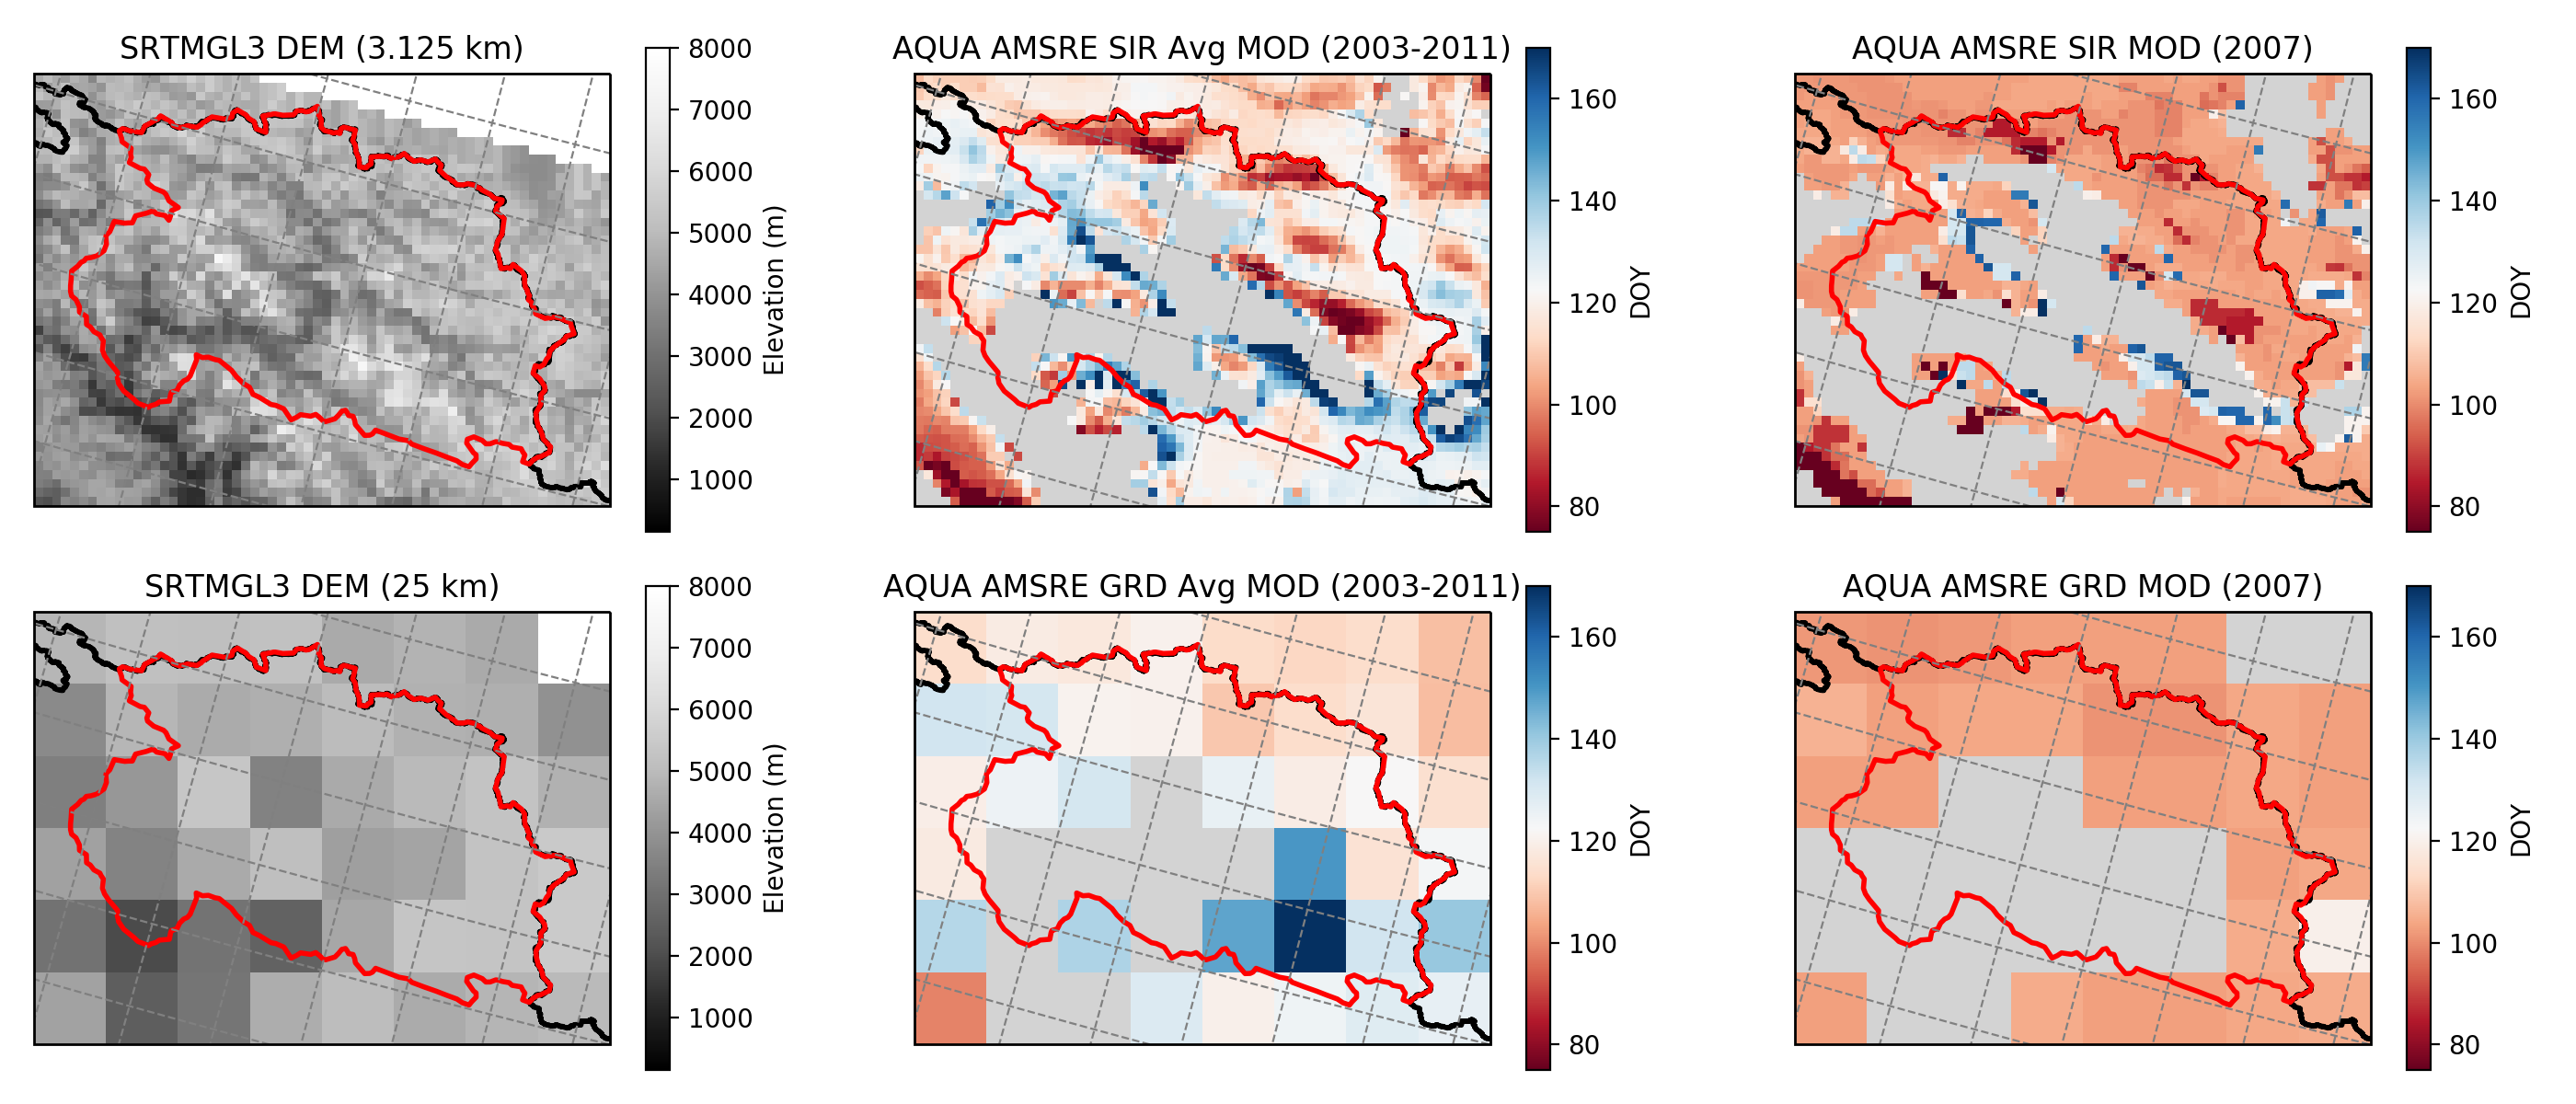

scales:  25000.0 -25000.0
Saved plot to /projects/brodzik/pmesdr_melt_onset/data/Hunza_AQUA_AMSRE_2003-2011_w2007.MOD.DAV040.Tb252.png


In [69]:
fig = plt.figure(figsize=(14,6))

# Figure out the extent to display and rotate the extent by 90 degrees
# This extent is for the current selected subset of the UIB cube
cube_extent=get_extent_xy(data_GRD['x'][rows_cols_GRD[2]:rows_cols_GRD[3]], 
                          data_GRD['y'][rows_cols_GRD[0]:rows_cols_GRD[1]])
cube_extentRotate=[cube_extent[2], cube_extent[3], -1.*cube_extent[1], -1. * cube_extent[0]]

# Placeholders for the various elements of each subplot
axes = []
images = []

numrows = 2
numcols = 3
numplots = numrows * numcols

labels = ["SRTMGL3 DEM (3.125 km)",
          "%s %s SIR Avg MOD (%4d-%4d)" % (platform, sensor, Years[0], Years[-1]),
          "%s %s SIR MOD (%s)" % (platform, sensor, year),
          "SRTMGL3 DEM (25 km)",
          "%s %s GRD Avg MOD (%4d-%4d)" % (platform, sensor, Years[0], Years[-1]),
          "%s %s GRD MOD (%s)" % (platform, sensor, year)]
color_labels = ["Elevation (m)",
                "DOY",
                "DOY",
                "Elevation (m)",
                "DOY",
                "DOY"]

# Set the projection and extent for each subplot
for i in np.arange(numplots):
    axes.append(fig.add_subplot(numrows, numcols, i+1, projection=e2nRotate))
    axes[i].set_extent(cube_extentRotate, crs=e2nRotate)

cmap = matplotlib.cm.RdBu
cmap.set_bad(color='lightgray')

images.append(axes[0].imshow(np.rot90(
    dem3km[rows_cols_env[0]:rows_cols_env[1], rows_cols_env[2]:rows_cols_env[3]], -1),
                             extent=cube_extentRotate, 
                             transform=e2nRotate,
                             origin='upper', cmap='Greys_r', 
                             interpolation='None', vmin=np.min(150), vmax=np.max(8000), label=labels[0]))

images.append(axes[1].imshow(np.rot90(MOD_DOY, -1), 
                             extent=cube_extentRotate, 
                             transform=e2nRotate,
                             origin='upper', 
                             cmap=cmap, 
                             interpolation='None', vmin=np.min(75), vmax=np.max(170), label=labels[1]))

images.append(axes[2].imshow(np.rot90(MOD_DOY_year, -1), 
              extent=cube_extentRotate, 
              transform=e2nRotate,
              origin='upper', cmap=cmap, 
              interpolation='None', vmin=np.min(75), vmax=np.max(170), label=labels[2]))

images.append(axes[3].imshow(np.rot90(
    dem25km[rows_cols_GRD[0]:rows_cols_GRD[1], rows_cols_GRD[2]:rows_cols_GRD[3]], -1),
                             extent=cube_extentRotate, 
                             transform=e2nRotate,
                             origin='upper', cmap='Greys_r', 
                             interpolation='None', vmin=np.min(150), vmax=np.max(8000), label=labels[3]))

images.append(axes[4].imshow(np.rot90(MOD_DOY_GRD, -1), 
                           extent=cube_extentRotate, 
                           transform=e2nRotate,
                           origin='upper', 
                             #cmap='RdBu',
                             cmap=cmap,
                           interpolation='None', vmin=np.min(75), vmax=np.max(170), label=labels[4]))

images.append(axes[5].imshow(np.rot90(MOD_DOY_GRD_year, -1), 
              extent=cube_extentRotate, 
              transform=e2nRotate,
              origin='upper', cmap=cmap, 
              interpolation='None', vmin=np.min(75), vmax=np.max(170), label=labels[5]))

# Do common display stuff for each subplot
for i in np.arange(numplots):
    axes[i].axis('off')
    axes[i].gridlines(color='gray', linestyle='--')
    axes[i].coastlines()
    axes[i].add_geometries([e2nRotateUIBBasin], 
                      e2nRotate,
                      edgecolors='black', facecolor='none', lw=2)
    axes[i].add_geometries([e2nRotateHunzaBasin], e2nRotate,
                      edgecolors='red', facecolor='none', lw=2)
    #For separate colorbars:
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    cbar = fig.colorbar(images[i], ax=axes[i])
    cbar.ax.set_ylabel(color_labels[i])
    axes[i].set_title(labels[i])

plt.tight_layout()
plt.show()
pngfile = "/projects/brodzik/pmesdr_melt_onset/data/%s_%s_%s_%d-%d_w%d.MOD.DAV%03d.Tb%03d.png" % (
    Site, platform, sensor, Years[0], Years[-1], year, DAV_threshold, Tb_threshold)
fig.savefig(pngfile, dpi=300)
print("Saved plot to %s" % pngfile)

In [38]:
cmap = matplotlib.cm.RdBu
cmap.set_bad(color='gray')
cmap

# Single map with SIR avg

<IPython.core.display.Javascript object>


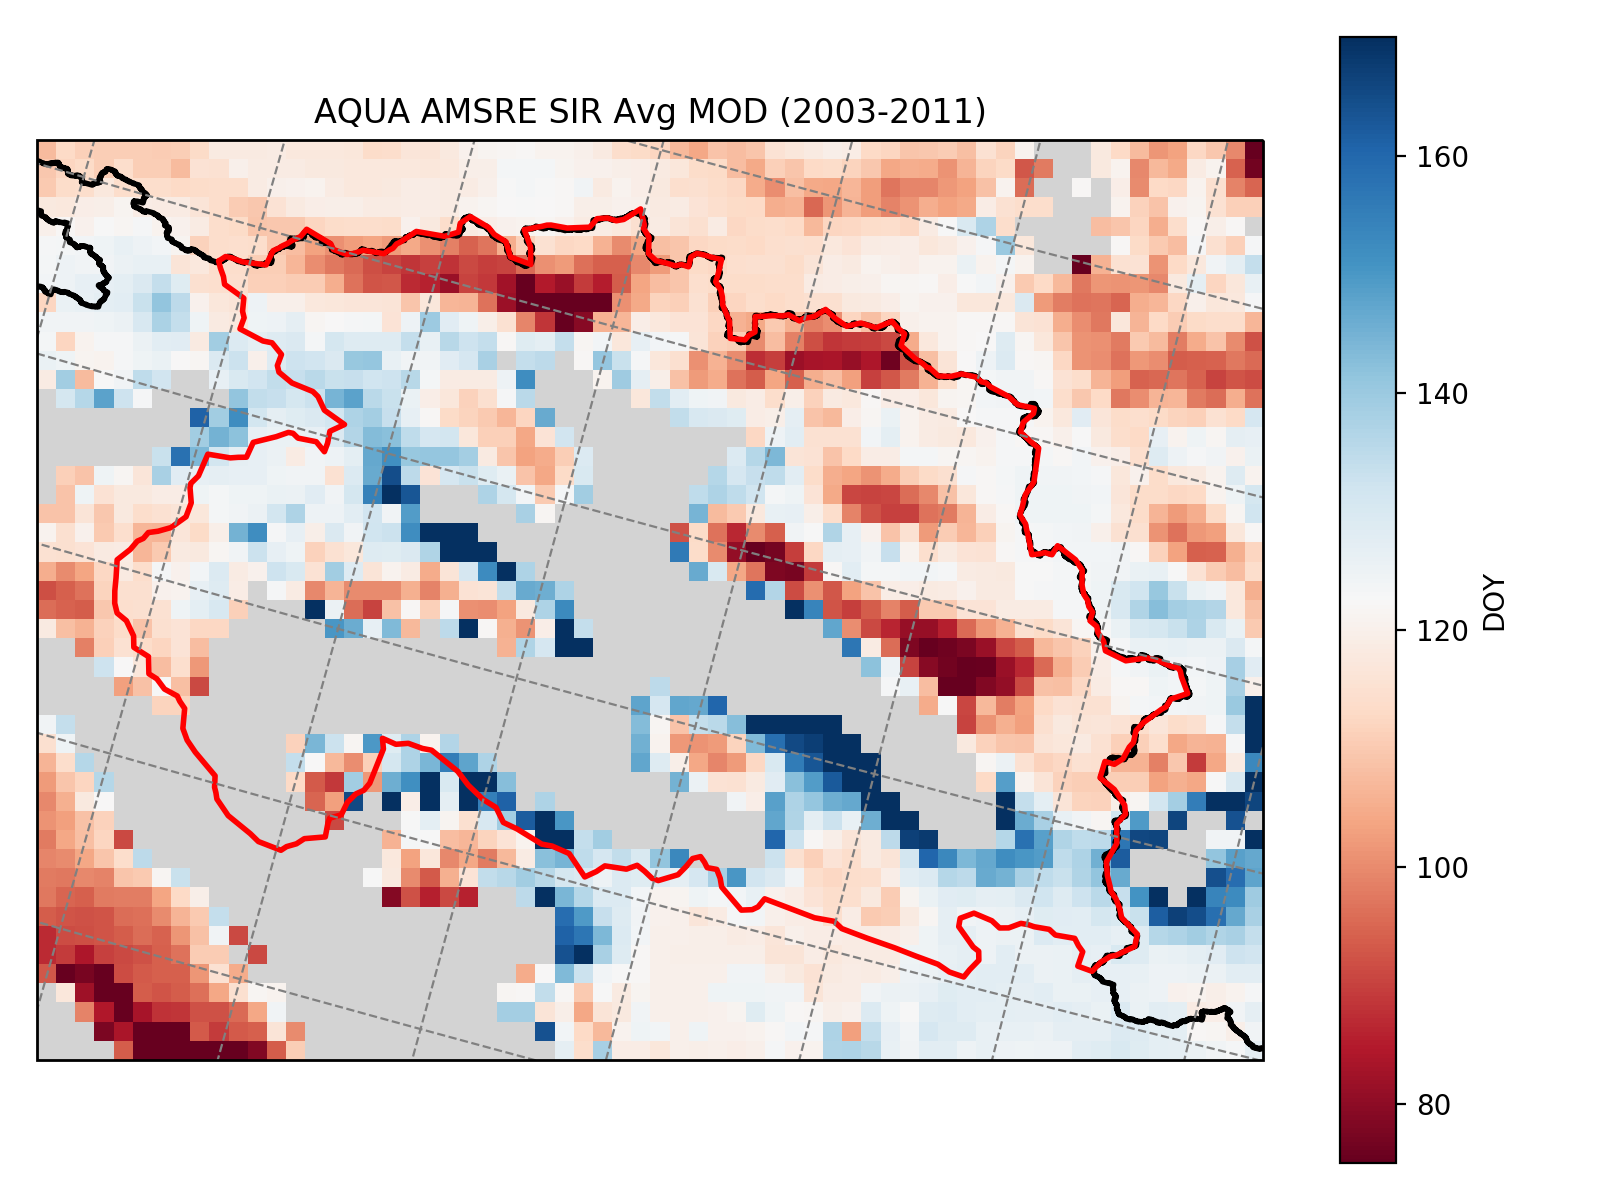

scales:  25000.0 -25000.0
Saved plot to /projects/brodzik/pmesdr_melt_onset/data/Hunza_AQUA_AMSRE_2003-2011_sirMOD.DAV040.Tb252.png


In [42]:
fig = plt.figure(figsize=(8,6))

# Figure out the extent to display and rotate the extent by 90 degrees
# This extent is for the current selected subset of the UIB cube
cube_extent=get_extent_xy(data_GRD['x'][rows_cols_GRD[2]:rows_cols_GRD[3]], 
                          data_GRD['y'][rows_cols_GRD[0]:rows_cols_GRD[1]])
cube_extentRotate=[cube_extent[2], cube_extent[3], -1.*cube_extent[1], -1. * cube_extent[0]]

# Placeholders for the various elements of each subplot
axes = []
images = []

numrows = 1
numcols = 1
numplots = numrows * numcols

labels = ["%s %s SIR Avg MOD (%4d-%4d)" % (platform, sensor, Years[0], Years[-1])]
color_labels = ["DOY"]

# Set the projection and extent for each subplot
for i in np.arange(numplots):
    axes.append(fig.add_subplot(numrows, numcols, i+1, projection=e2nRotate))
    axes[i].set_extent(cube_extentRotate, crs=e2nRotate)

cmap = matplotlib.cm.RdBu
cmap.set_bad(color='lightgray')

images.append(axes[0].imshow(np.rot90(MOD_DOY, -1), 
                             extent=cube_extentRotate, 
                             transform=e2nRotate,
                             origin='upper', 
                             cmap=cmap, 
                             interpolation='None', vmin=np.min(75), vmax=np.max(170), label=labels[0]))

# Do common display stuff for each subplot
for i in np.arange(numplots):
    axes[i].axis('off')
    axes[i].gridlines(color='gray', linestyle='--')
    axes[i].coastlines()
    axes[i].add_geometries([e2nRotateUIBBasin], 
                      e2nRotate,
                      edgecolors='black', facecolor='none', lw=2)
    axes[i].add_geometries([e2nRotateHunzaBasin], e2nRotate,
                      edgecolors='red', facecolor='none', lw=2)
    #For separate colorbars:
    cbar = fig.colorbar(images[i], ax=axes[i])
    cbar.ax.set_ylabel(color_labels[i])
    axes[i].set_title(labels[i])

plt.tight_layout()
plt.show()
pngfile = "/projects/brodzik/pmesdr_melt_onset/data/%s_%s_%s_%d-%d_sirMOD.DAV%03d.Tb%03d.png" % (
    Site, platform, sensor, Years[0], Years[-1], DAV_threshold, Tb_threshold)
fig.savefig(pngfile, dpi=300)
print("Saved plot to %s" % pngfile)

# Single map with GRD avg

<IPython.core.display.Javascript object>


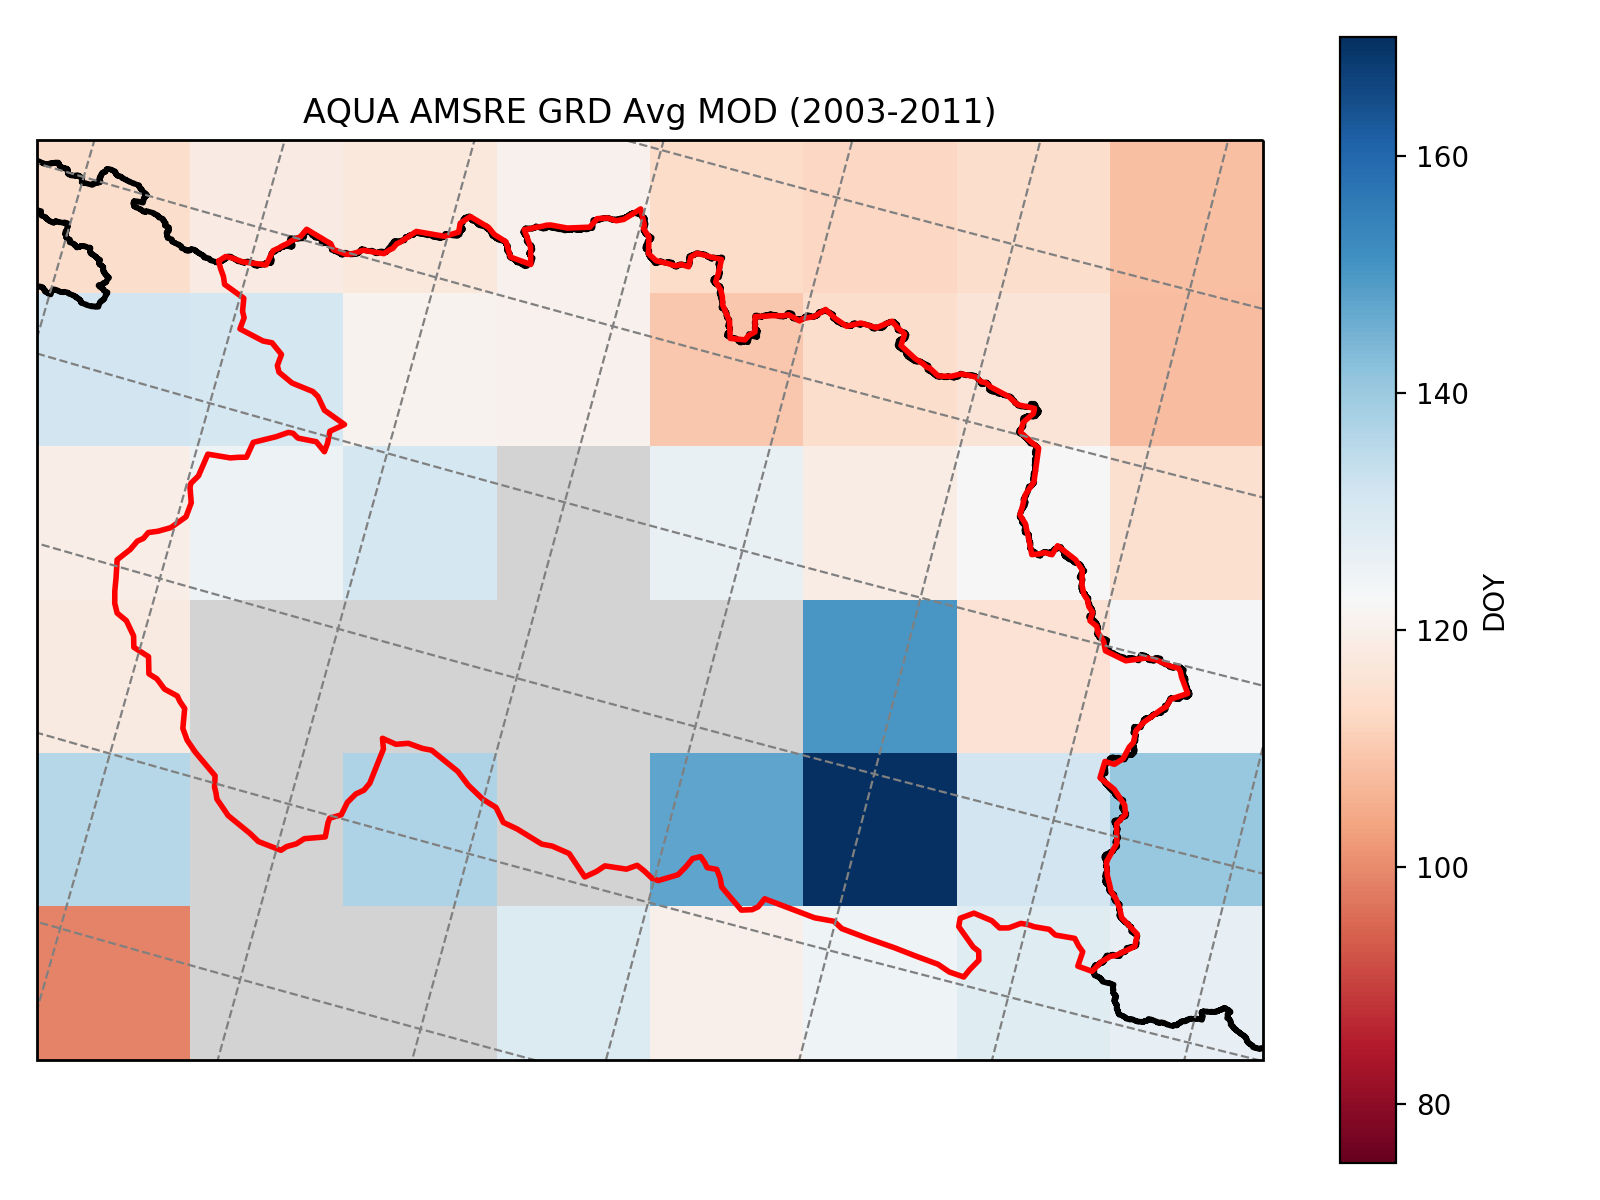

scales:  25000.0 -25000.0
Saved plot to /projects/brodzik/pmesdr_melt_onset/data/Hunza_AQUA_AMSRE_2003-2011_grdMOD.DAV040.Tb252.png


In [51]:
fig = plt.figure(figsize=(8,6))

# Figure out the extent to display and rotate the extent by 90 degrees
# This extent is for the current selected subset of the UIB cube
cube_extent=get_extent_xy(data_GRD['x'][rows_cols_GRD[2]:rows_cols_GRD[3]], 
                          data_GRD['y'][rows_cols_GRD[0]:rows_cols_GRD[1]])
cube_extentRotate=[cube_extent[2], cube_extent[3], -1.*cube_extent[1], -1. * cube_extent[0]]

# Placeholders for the various elements of each subplot
axes = []
images = []

numrows = 1
numcols = 1
numplots = numrows * numcols

labels = ["%s %s GRD Avg MOD (%4d-%4d)" % (platform, sensor, Years[0], Years[-1])]
color_labels = ["DOY"]

# Set the projection and extent for each subplot
for i in np.arange(numplots):
    axes.append(fig.add_subplot(numrows, numcols, i+1, projection=e2nRotate))
    axes[i].set_extent(cube_extentRotate, crs=e2nRotate)

cmap = matplotlib.cm.RdBu
cmap.set_bad(color='lightgray')

images.append(axes[0].imshow(np.rot90(MOD_DOY_GRD, -1), 
                             extent=cube_extentRotate, 
                             transform=e2nRotate,
                             origin='upper', 
                             cmap=cmap, 
                             interpolation='None', vmin=np.min(75), vmax=np.max(170), label=labels[0]))

# Do common display stuff for each subplot
for i in np.arange(numplots):
    axes[i].axis('off')
    axes[i].gridlines(color='gray', linestyle='--')
    axes[i].coastlines()
    axes[i].add_geometries([e2nRotateUIBBasin], 
                      e2nRotate,
                      edgecolors='black', facecolor='none', lw=2)
    axes[i].add_geometries([e2nRotateHunzaBasin], e2nRotate,
                      edgecolors='red', facecolor='none', lw=2)
    #For separate colorbars:
    cbar = fig.colorbar(images[i], ax=axes[i])
    cbar.ax.set_ylabel(color_labels[i])
    axes[i].set_title(labels[i])

plt.tight_layout()
plt.show()
pngfile = "/projects/brodzik/pmesdr_melt_onset/data/%s_%s_%s_%d-%d_grdMOD.DAV%03d.Tb%03d.png" % (
    Site, platform, sensor, Years[0], Years[-1], DAV_threshold, Tb_threshold)
fig.savefig(pngfile, dpi=300)
print("Saved plot to %s" % pngfile)